# Reconstruction of volume from simulated data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax.config import config
import time
import mrcfile
from simplecryoem.external.pyem import star

from simplecryoem.ab_initio import ab_initio_mcmc
from simplecryoem.forwardmodel import (
    project,
    apply_shifts_and_ctf,
    Slice,
    rotate_and_interpolate,
)
from simplecryoem.optimization import (
    Loss,
    GradV,
    sgd,
    get_sgd_vol_ops,
    conjugate_gradient,
    get_cg_vol_ops,
)
from simplecryoem.sampling import mcmc_sampling, proposal_hmc, CryoProposals
from simplecryoem.fsc import calc_fsc, shell_points_used, points_orientations_tri
from simplecryoem.utils import (
    volume_fourier,
    volume_comp,
    mip_y,
    mip_z,
    create_3d_mask,
    generate_uniform_orientations,
    generate_uniform_orientations_jax,
    generate_gaussian_shifts,
    generate_uniform_shifts,
    crop_fourier_images,
    crop_fourier_volume,
    plot_angles,
    wrap_around_distance_2d_array,
)

In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

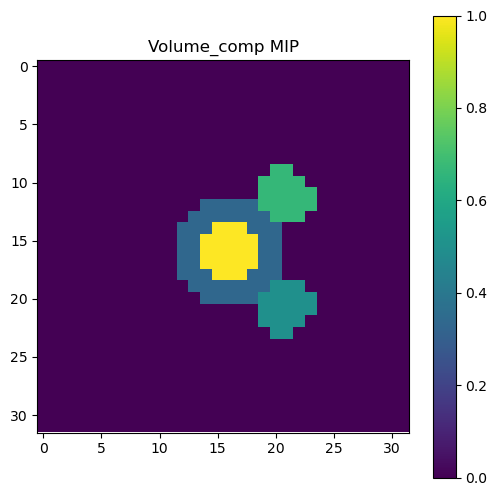

In [3]:
nx = 32
shape = np.array([nx, nx, nx])
dimensions = np.array([20, 20, 20])
pixel_size = dimensions[0] / shape[0]

# A volume with components
centres = np.array([[0, 0, 0], [3, 3, 0], [3, -3, 0], [0, 0, 3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10, 15, 20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
# plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title("Volume_comp MIP")

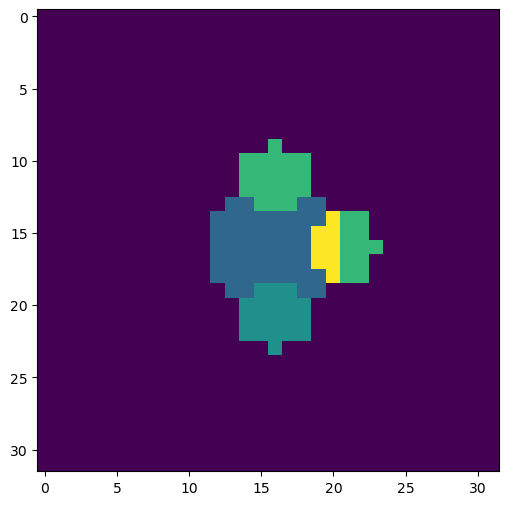

In [4]:
mip_y(vol)

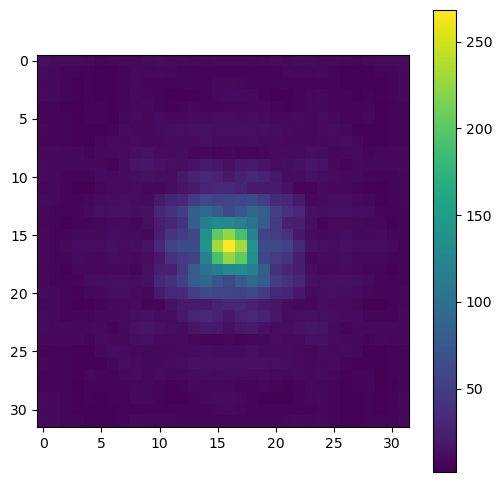

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier))))
plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("../comparisons/data/pyem.star", keep_index=False)
dfiter = df.iterrows()
_, p = next(dfiter)

# ctf_params = {'def1'  : p[star.Relion.DEFOCUSU],
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE],
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC],
#              'cs'    : p[star.Relion.CS],
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array(
    [
        p[star.Relion.DEFOCUSU],
        p[star.Relion.DEFOCUSV],
        p[star.Relion.DEFOCUSANGLE],
        p[star.Relion.PHASESHIFT],
        p[star.Relion.VOLTAGE],
        p[star.Relion.AC],
        p[star.Relion.CS],
        0,
        2 * pixel_size,
    ]
)

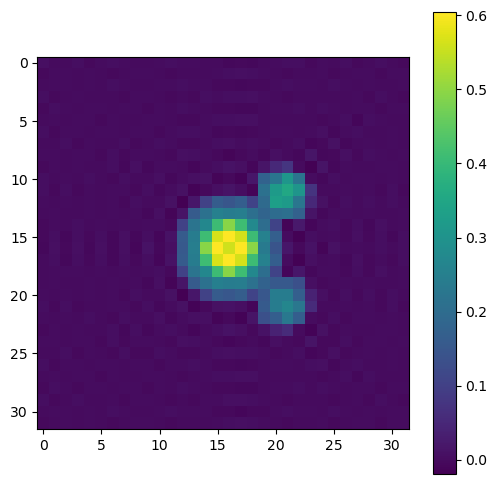

In [7]:
radius = 0.8
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'nn')

#slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(
#    project, x_grid, mask, "nn"
#)
s = 17
img = slice_obj.slice(0.1 * vol_fourier, [0, 0, 0], [0, 0], jnp.array([None]))
img_r = jnp.fft.fftshift(jnp.real(jnp.fft.ifft2((img.reshape([nx, nx])))))
plt.imshow(img_r)
plt.colorbar()

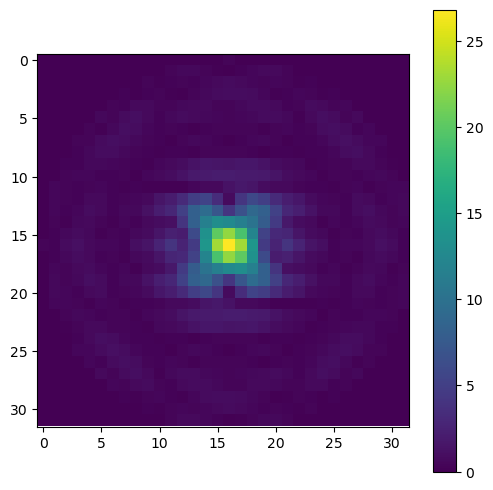

In [8]:
img_f0 = jnp.fft.fftshift(img.reshape([nx, nx]))
plt.imshow(jnp.abs(img_f0))
plt.colorbar()

Generate projections (in Fourier domain)

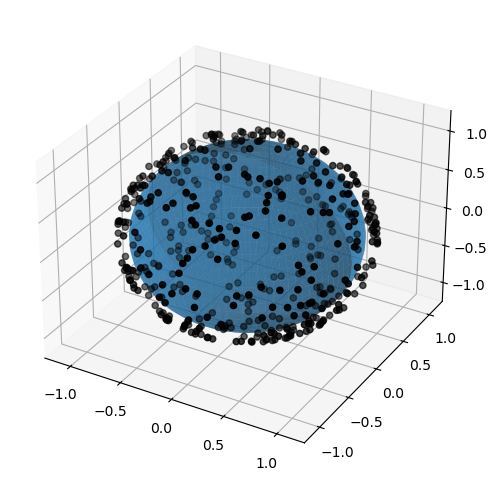

In [9]:
# Orientations
N = 5000

# s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
# jnp.array(np.random.rand(N,3))*jnp.pi*2

# angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
# angles_true = s*np.random.randn(int(N),3)
# angles_true = np.concatenate([s*np.random.randn(2250,3),
#                             s*np.random.randn(2250,3)+np.pi*2/3,
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
# np.random.shuffle(angles_true)
# angles_true = jnp.array(angles_true)

# angles_true = np.zeros([N,3])
# angles_true[:,1] = s*np.random.randn(N) - np.pi/2
# angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

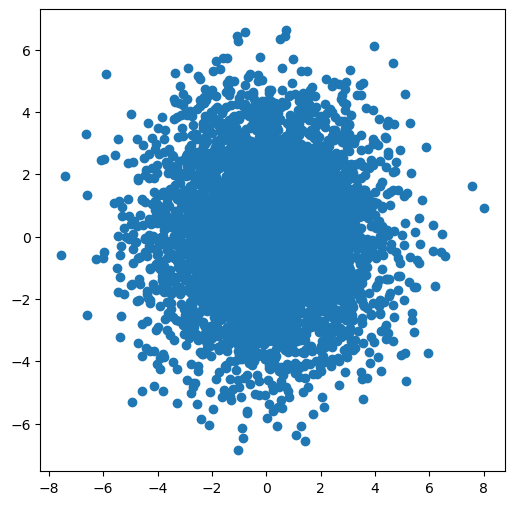

In [10]:
# Shifts
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
key, subkey = random.split(key)
# shifts_true = generate_uniform_shifts(key, N, pixel_size*nx/2)
shifts_true = generate_gaussian_shifts(key, N, pixel_size * nx / 10)

# shifts_true = jnp.zeros([N,3])

plt.scatter(shifts_true[:, 0], shifts_true[:, 1])

SNR = 0.15675976607683614
sigma = 37.84951113740295


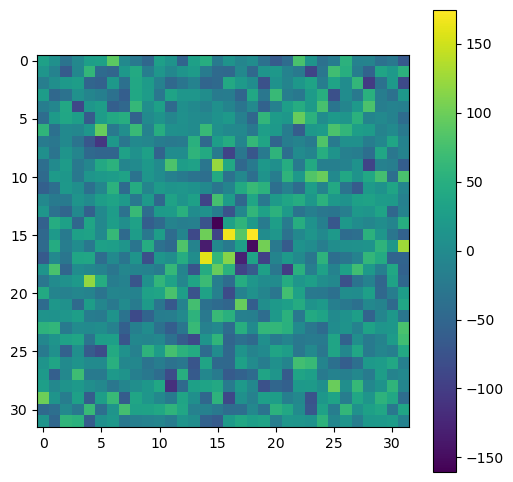

In [11]:
radius = 0.8
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'nn')

img0 = slice_obj.slice(vol_fourier, [0, 0, 0], [0, 0], ctf_params0)


ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_obj.slice_array(vol_fourier, angles_true, shifts_true, ctf_params)

# If too many images which don't fit in the gpu memory, do this:
# imgs = jnp.array([slice_func(vol_fourier, angles_true[i], shifts_true[i], ctf_params0) for i in range(N)])

norm0sq = jnp.real(jnp.sum(jnp.conj(imgs) * imgs))

# Noise
sigma = 0.2 * jnp.max(jnp.abs(img0))
imgs += (np.random.randn(N, nx * nx) + 1j * np.random.randn(N, nx * nx)) * sigma

norm1sq = jnp.real(jnp.sum(jnp.conj(imgs) * imgs))

# print(time.time()-start)

# SNR
print("SNR =", norm0sq / norm1sq)
print("sigma =", sigma)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[101].reshape(nx, nx))))
plt.colorbar()

### Crop images and volume:

In [12]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx * nx)
    # imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

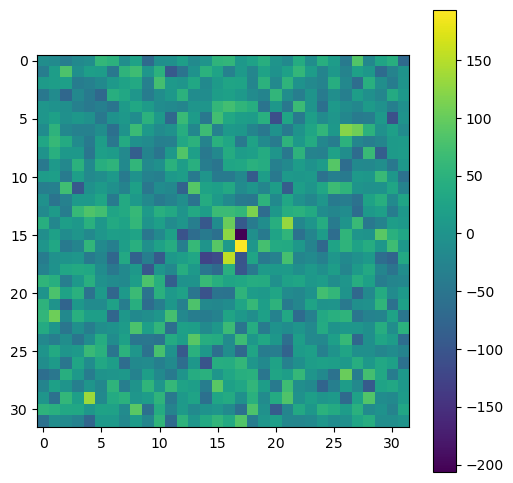

In [13]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx, nx))))
plt.colorbar()

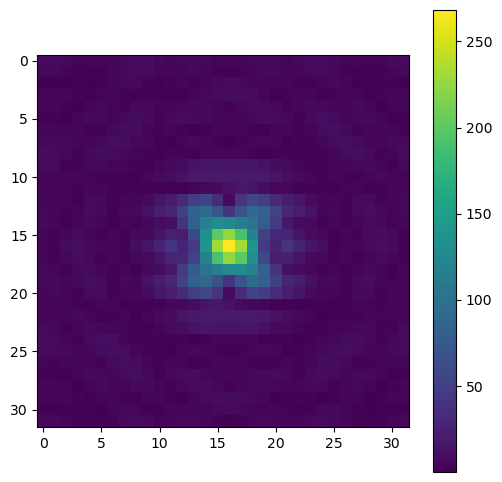

In [14]:
# mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:, :, 0]))))
plt.colorbar()

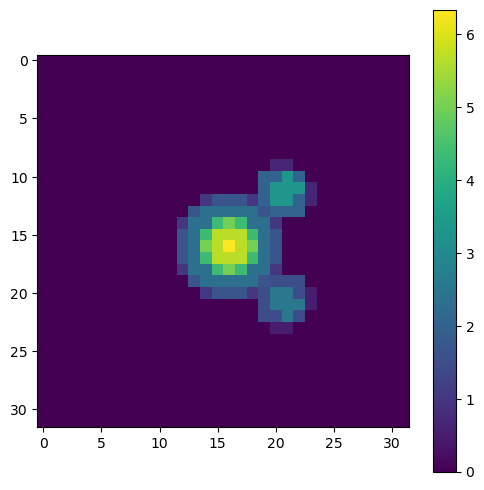

In [15]:
# mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:, :, 0]))))
plt.colorbar()

### Loss functions for the new dimension

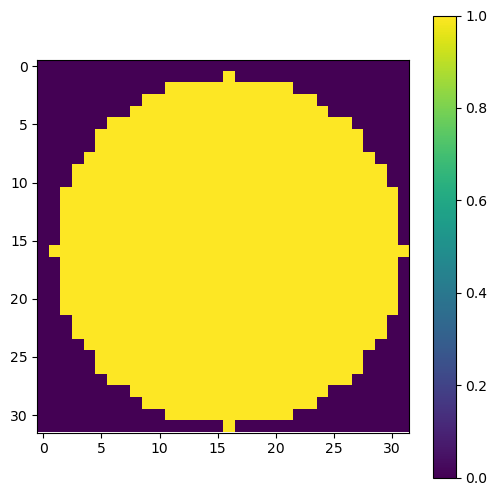

In [17]:
alpha = 0.01
# alpha = 1/N

#radius = 0.2 # for nx =8
# radius = 0.4 # for nx=16
radius = 0.75  # for nx=32
# radius = 1.6 # for nx=64
# radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
mip_z(jnp.fft.fftshift(mask))
plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'tri')
loss_obj = Loss(slice_obj, alpha=alpha)
grad_obj = GradV(loss_obj)

In [18]:
sigma_noise = jnp.ones(nx * nx) * sigma

In [19]:
start = time.time()
ll = loss_obj.loss_batched(
    vol_fourier,
    angles_true[:20],
    shifts_true[:20],
    ctf_params[:20],
    imgs[:20],
    sigma_noise,
)
# ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time() - start)
print(ll.shape)

8.65087628364563
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [20]:
start = time.time()
ll = grad_obj.grad_loss_volume(
    np.random.randn(nx, nx, nx),
    angles_true[0],
    shifts_true[0],
    ctf_params[0],
    imgs[0],
    sigma_noise,
)
print(time.time() - start)
print(ll.shape)

1.107276201248169
(32, 32, 32)


In [21]:
batch_size = N
idx = np.random.default_rng().choice(N, size=batch_size, replace=False)

start = time.time()
ll = grad_obj.grad_loss_volume_sum(
    np.random.randn(nx, nx, nx),
    angles_true[idx],
    shifts_true[idx],
    ctf_params[idx],
    imgs[idx],
    sigma_noise,
)
print(time.time() - start)
print(ll.shape)

1.1107335090637207
(32, 32, 32)


### MCMC - vol

In [22]:
vol_fourier.shape

(32, 32, 32)

In [23]:
def plot_true_vs_estimated(vol_true, vol_estimated):
    plt.rcParams["figure.figsize"] = 16, 16
    plt.subplot(2, 2, 1)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_true[:, :, 0])))
    plt.colorbar()
    plt.title("True")
    plt.subplot(2, 2, 2)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_estimated[:, :, 0])))
    plt.colorbar()
    plt.title("Sampled")
    plt.subplot(2, 2, 3)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_true[:, :, 0]))))
    plt.colorbar()
    plt.title("True")
    plt.subplot(2, 2, 4)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_estimated[:, :, 0]))))
    plt.colorbar()
    plt.title("Estimated")

    plt.rcParams["figure.figsize"] = 8, 8

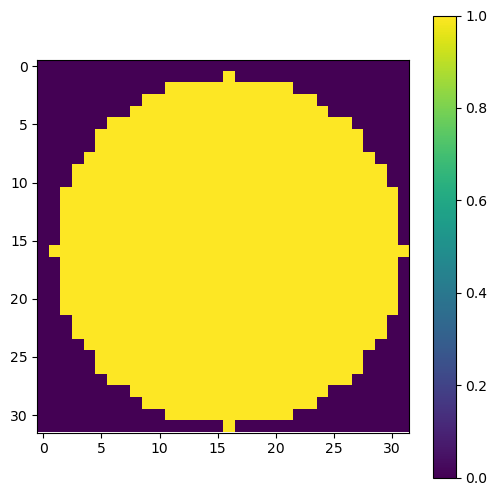

In [32]:
# alpha = 1e-10
# alpha = 0.001

#radius_mask = 0.2 # for nx=8
radius_mask = 0.75  # nx=32
# radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0, 0, 0), radius_mask)
mip_z(jnp.fft.fftshift(mask))
plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'tri')
loss_obj = Loss(slice_obj, alpha=alpha)
grad_obj = GradV(loss_obj)

logPi = lambda v: -loss_obj.loss_sum(v, angles_true, shifts_true, ctf_params, imgs, 1)
gradLogPi = lambda v: -jnp.conj(
    grad_obj.grad_loss_volume_sum(v, angles_true, shifts_true, ctf_params, imgs, 1)
)

In [33]:
dt_list = jnp.array([0.5])
L = 10
M = 1

@jax.jit
def proposal_hmc_jit(key, x0, logPiX0, dt_list):
    return proposal_hmc(key, x0, logPiX0, logPi, gradLogPi, dt_list, L, M)

In [38]:
N_mc_samples = 200

key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
v0 = jnp.array(np.random.randn(nx, nx, nx) + 1j * np.random.randn(nx, nx, nx))
logPiX0 = logPi(v0)

proposal_params = {'dt_list' : dt_list}

t0 = time.time()
v_hmc_mean, r_hmc, v_hmc_samples = mcmc_sampling(key, proposal_hmc_jit, v0, N_mc_samples, proposal_params,verbose=True,iter_display=10)
print((time.time() - t0) / N_mc_samples)
v_hmc_mean = v_hmc_mean * mask

  MCMC sample 10, posterior val = -1512970.6153722894, a = 1.0
  MCMC sample 20, posterior val = -1512816.3823477654, a = 1.0
  MCMC sample 30, posterior val = -1513062.406005487, a = 1.0
  MCMC sample 40, posterior val = -1513030.625137804, a = 1.0
  MCMC sample 50, posterior val = -1513124.7577415965, a = 0.973284270935502
  MCMC sample 60, posterior val = -1513108.4149583352, a = 1.0
  MCMC sample 70, posterior val = -1513040.4308330822, a = 1.0
  MCMC sample 80, posterior val = -1513158.9155858057, a = 1.0
  MCMC sample 90, posterior val = -1513030.9651233272, a = 0.994788670141442
  MCMC sample 100, posterior val = -1513076.4443881984, a = 1.0
  MCMC sample 110, posterior val = -1513048.2994659813, a = 0.9047347701884596
  MCMC sample 120, posterior val = -1513052.6657661428, a = 1.0
  MCMC sample 130, posterior val = -1513002.6304034695, a = 0.9481170837205699
  MCMC sample 140, posterior val = -1513183.2800199527, a = 0.9729947761517291
  MCMC sample 150, posterior val = -151306

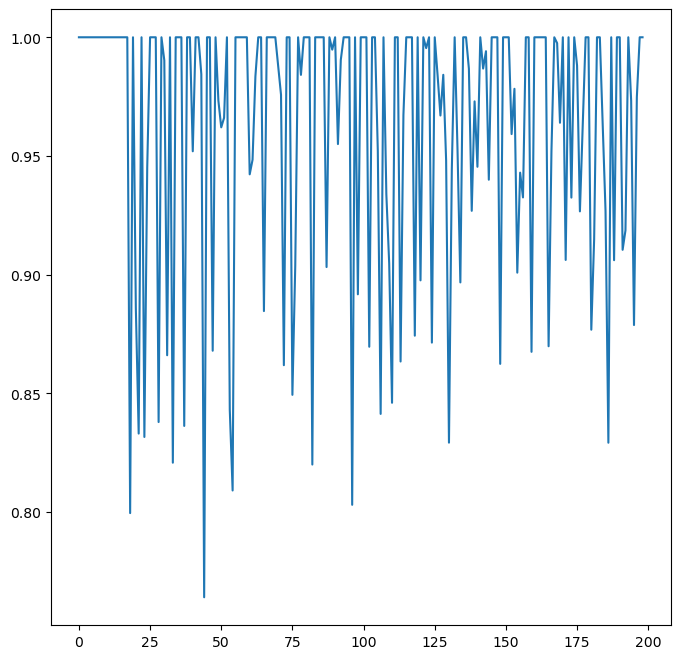

In [39]:
plt.plot(r_hmc)

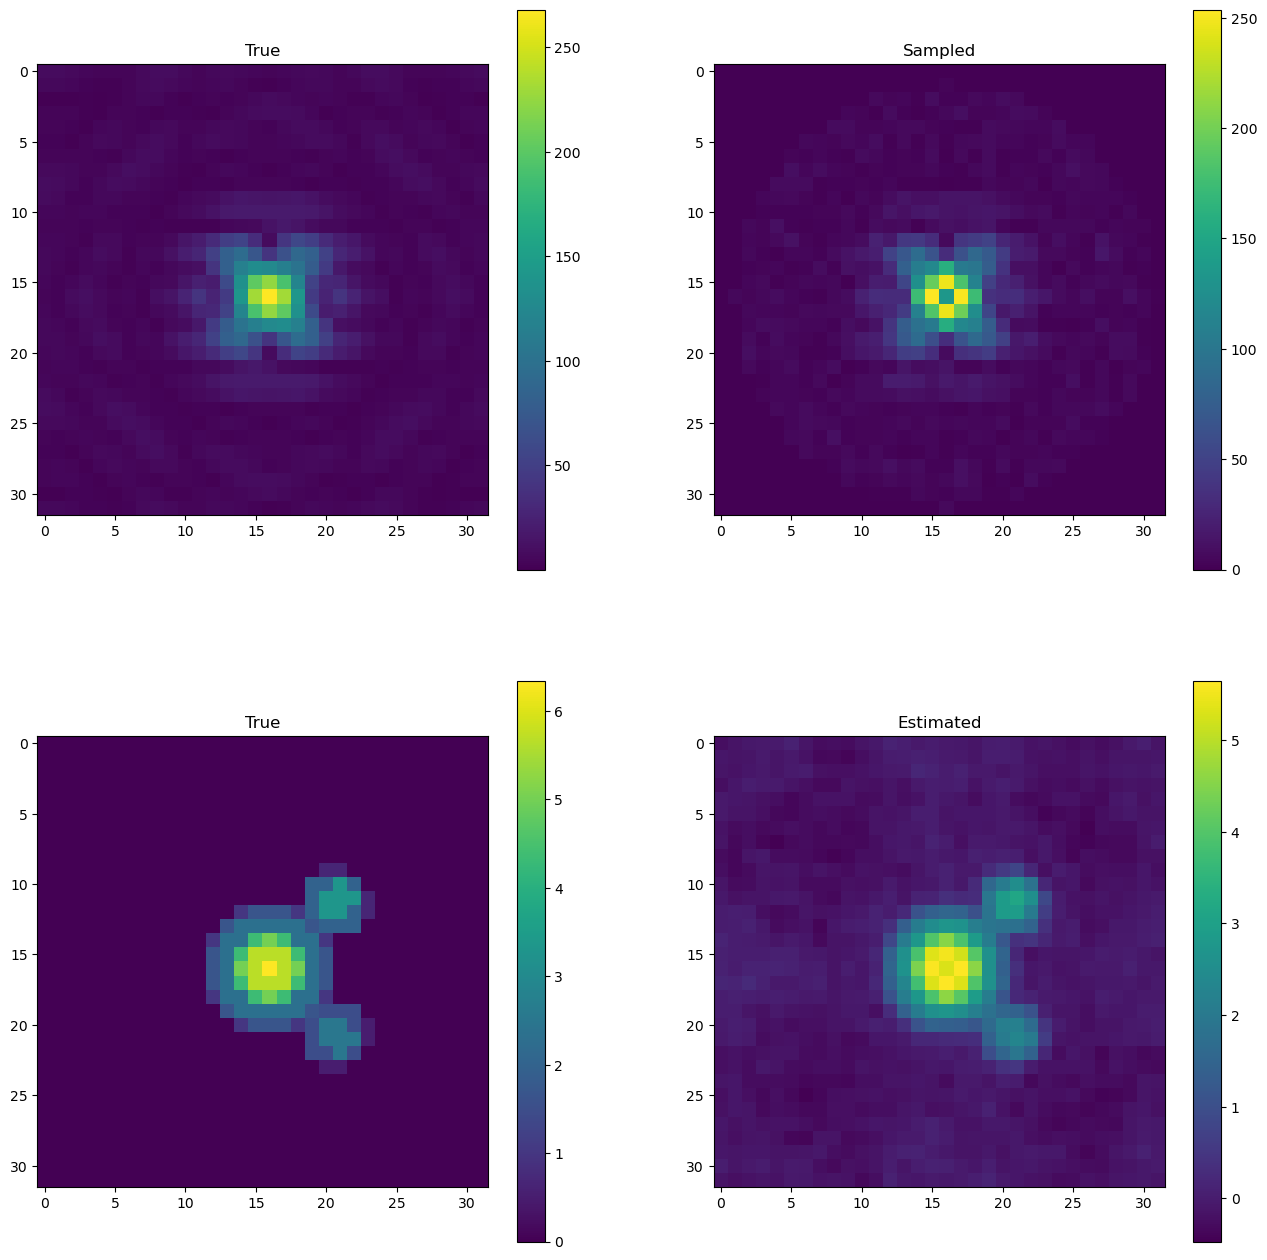

In [40]:
plot_true_vs_estimated(vol_fourier, v_hmc_mean)

In [41]:
print(loss_obj.loss_sum(vol_fourier, angles_true, shifts_true, ctf_params, imgs, 1))
print(loss_obj.loss_sum(v_hmc_mean, angles_true, shifts_true, ctf_params, imgs, 1))
# print(loss_func_sum(v_rec, angles_rec, shifts_true, ctf_params, imgs, 1))
# print(loss_func_sum(vcg1, angles_rec, shifts_true, ctf_params, imgs, 1))

1502188.286251019
1497030.6360422582


# TODO: this notebook needs to be updated from this point onward

### MCMC - orientations

In [ ]:
alpha0 = 0

radius = 0.4
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(
    project, x_grid, mask, "tri"
)
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(
    slice_func, alpha=alpha0
)
logPi_batch = lambda a: -loss_func_batched(
    vol_fourier, a, shifts_true, ctf_params, imgs, 1
)


def proposal_uniform_orientations_func(key, x0):
    return proposal_uniform_orientations(key, x0, logPi_batch)

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_mc_samples = 1001

angles0 = generate_uniform_orientations_jax(key, N)
t0 = time.time()
angles_mean, r_samples_angles, samples_angles = mcmc(
    key, proposal_uniform_orientations_func, angles0, N_mc_samples, logPi_batch, N
)
print(time.time() - t0)

angles_rec = samples_angles[0]

In [ ]:
key, *keys = random.split(key, N_mc_samples + 1)
angles0 = generate_uniform_orientations_jax(key, N)
# print(jnp.mean(loss_angles(angles0))/(nx*nx*jnp.max(jnp.abs(imgs))))
print(jnp.max(jnp.abs(logPi_batch(angles0))))

t0 = time.time()
for i in range(N_mc_samples):
    angles1 = mcmc_batch_step(keys[i], N_mc_samples, logPi_batch, angles0)
    angles0 = angles1

    if jnp.mod(i, 100) == 0:
        # loss_i = jnp.mean(loss_angles(angles1))/(nx*nx*jnp.max(jnp.abs(imgs)))
        loss_i = jnp.max(jnp.abs(logPi_batch(angles1)))
        print("Iter", i, ", loss = ", loss_i)

print(time.time() - t0)

In [ ]:
angles0 = generate_uniform_orientations_jax(key, N)

print(jnp.max(jnp.abs(logPi_batch(angles0))))
print(jnp.max(jnp.abs(logPi_batch(angles_true))))
print(jnp.max(jnp.abs(logPi_batch(angles1))))
print(jnp.max(jnp.abs(logPi_batch(angles_rec))))

### MCMC shifts

#### Naive

In [ ]:
alpha0 = 0
B = pixel_size * nx / 10

radius = 0.4
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(
    project, x_grid, mask, "tri"
)
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(
    slice_func, alpha=alpha0
)
logPi_shifts = lambda sh: -loss_func_batched(
    vol_fourier, angles_true, sh, ctf_params, imgs, 1
)


def proposal_uniform_shifts_func(key, x0):
    return proposal_uniform_shifts(key, x0, logPi_shifts, B)

In [ ]:
B

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_mc_samples = 2001

shifts0 = generate_uniform_shifts(key, N, B)
t0 = time.time()
_, r_samples_shifts, shifts_samples = mcmc(
    key, proposal_uniform_shifts_func, shifts0, N_mc_samples, logPi_shifts, N
)
print(time.time() - t0)

shifts_rec = shifts_samples[0]

In [ ]:
plt.plot(r_samples_shifts[:, 10])

In [ ]:
shifts_err = wrap_around_distance_2d_array(shifts_true, shifts_rec, B)
print("mean shift error =", jnp.mean(shifts_err), "in [", -B, ",", B, "]^2")
plt.plot(shifts_err)

#### Optimised

In [ ]:
alpha0 = 0
B = pixel_size * nx / 10

radius = 0.4
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

proj = jax.vmap(rotate_and_interpolate, in_axes=(None, 0, None, None))(
    vol_fourier * mask, angles_true, x_grid, x_grid
)

In [ ]:
loss_proj_func_batched = get_loss_proj_funcs(apply_shifts_and_ctf, x_grid, alpha=alpha0)
logPi_shifts = lambda sh: -loss_proj_func_batched(
    vol_fourier, proj, sh, ctf_params, imgs, 1
)


@jax.jit
def proposal_uniform_shifts_func(key, x0):
    return proposal_uniform_shifts(key, x0, logPi_shifts, B)


@jax.jit
def proposal_gaussian_shifts_func(key, x0):
    return proposal_gaussian_shifts(key, x0, logPi_shifts, B)

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_mc_samples = 101

shifts0 = generate_gaussian_shifts(key, N, B)
t0 = time.time()
_, r_samples_shifts, shifts_samples = mcmc(
    key, proposal_gaussian_shifts_func, shifts0, N_mc_samples, logPi_shifts, N
)
print(time.time() - t0)

shifts_rec = shifts_samples[0]

In [ ]:
plt.plot(r_samples_shifts[:, 10])

In [ ]:
shifts_err = wrap_around_distance_2d_array(shifts_true, shifts_rec, B)
print("mean shift error =", jnp.mean(shifts_err), "in [", -B, ",", B, "]^2")
plt.plot(shifts_err)

### Ab initio

In [ ]:
sh = generate_gaussian_shifts(key, N, nx * pixel_size / 10)
plt.plot(shifts_true[:, 0], shifts_true[:, 1], ".")
plt.plot(sh[:, 0], sh[:, 1], ".")

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

N_samples = 1000
N_iter = 100000

dr = 0.05
radius = 0.2
# alpha = 0.001
alpha = 1e-7

use_sgd = True

N_cg_iter = 1000

N_sgd_iter = 100
batch_size = 500
learning_rate = 1
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

vol0 = None
angles0 = None
shifts0 = None

N_samples_vol = 101
N_samples_angles = 1000
N_samples_shifts = 1000

eps_vol = 2e-5

# HMC params
dt_list = jnp.array([0.1, 0.5, 1, 5])
L = 10

# boundary for sampling shifts in [-B, B]^2
B = pixel_size * nx / 10

out_dir = "../data/ab_initio/"
imgs = imgs.reshape([N, nx * nx])
# v_rec, angles_rec = ab_initio(project, imgs, sigma_noise, shifts_true, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec, shifts_rec = ab_initio_mcmc(
    key,
    project,
    rotate_and_interpolate,
    apply_shifts_and_ctf,
    imgs,
    sigma_noise,
    ctf_params,
    x_grid,
    use_sgd,
    vol0,
    angles0,
    shifts0,
    N_iter,
    learning_rate,
    batch_size,
    P,
    N_samples_vol,
    N_samples_angles,
    N_samples_shifts,
    dt_list,
    L,
    radius,
    dr,
    alpha,
    eps_vol,
    B,
    "tri",
    True,
    True,
    True,
    out_dir,
)

In [ ]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[:, :, 0]))))
plt.colorbar()

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:, :, 0])))
plt.colorbar()

In [ ]:
plot_angles(angles_rec[:1000])

In [ ]:
shifts_err = wrap_around_distance_2d_array(shifts_true, shifts_rec, 10)
print("mean shift error =", jnp.mean(shifts_err), "in [", -10, ",", 10, "]^2")
plt.plot(shifts_err)

In [ ]:
plot_angles(angles_true[:1000])

## Optimization with respect to volume

### CG - applied to two halves of the data

In [ ]:
v0 = jnp.array(np.random.randn(nx, nx, nx) + 1j * np.random.randn(nx, nx, nx))
N_iter = 600
eps_cg = 1e-5

N2 = jnp.floor(N / 2).astype(jnp.int64)
# N2 = 100000
AA1, Ab1 = get_cg_vol_ops(
    grad_loss_volume_sum,
    angles_true[:N2],
    shifts_true[:N2],
    ctf_params[:N2],
    imgs[:N2],
    v0.shape,
)

vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, eps_cg, verbose=True)

In [ ]:
AA2, Ab2 = get_cg_vol_ops(
    grad_loss_volume_sum,
    angles_true[N2:],
    shifts_true[N2:],
    ctf_params[N2:],
    imgs[N2:],
    v0.shape,
)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, eps_cg, verbose=True)

In [ ]:
# print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print(
    "Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier) / jnp.max(vol_fourier)))
)
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

In [ ]:
# mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ;
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0, :, :]))))
plt.colorbar()

In [ ]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx, nx)))
plt.colorbar()

In [ ]:
# mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:, :, 0]))))
plt.colorbar()
# plt.title('Reconstruction slice')

In [ ]:
# mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[0, :, :]))))
plt.colorbar()
plt.title("Reconstruction MIP")

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1 - vol_fourier) / jnp.max(vol_fourier))))
plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title("Error in spatial domain with low freq vol - MIP")

In [ ]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))

with mrcfile.new("../data/simulated_rec_vhmc.mrc", overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

In [ ]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier)))

with mrcfile.new("../data/simulated_vol_16.mrc", overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

### FSC

In [ ]:
res, fsc, shell_points = calc_fsc(vcg1, v_hmc_max, x_grid, dr=0.05)

In [ ]:
points_v_tri = points_orientations_tri(angles_true[: int(N / 2)], int(x_grid[1]))
# points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [ ]:
# points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr=0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines(
    [0.143, 0.5], xmin=min(res), xmax=max(res), colors=["gray"], linestyles=["dashed"]
)
plt.legend(["FSC", "fraction shell points used", "0.143, 0.5"])
# plt.title('Clustered angles')

In [ ]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0, :, :] * mask[0, :, :])))
plt.colorbar()

In [ ]:
# res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
# plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1 / omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0, :, :])))))
plt.colorbar()

In [ ]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:, :, 0]))))
plt.colorbar()

### SGD

#### A preconditioner

In [ ]:
points_v_nn.shape
P = points_v_nn
P += 0.1
P = 1 / P * mask

P = P / jnp.max(P)

plt.imshow(jnp.fft.fftshift(P[:, :, 0]))
plt.colorbar()
print(P[0, 0, 0])
print(jnp.max(P))

In [ ]:
v0 = jnp.array(np.random.randn(nx, nx, nx) + 1j * np.random.randn(nx, nx, nx))
batch_size = N / 2
N_epoch = 100
eps_gd = 1e-3
learning_rate = 1
# alpha = 100000 # <- with normalized precon

sgd_grad_func = get_sgd_vol_ops(
    grad_loss_volume_batched, angles_true, shifts_true, ctf_params, imgs
)
vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, None, eps_gd, True)

print(
    "Final loss function (over all data) = ",
    jnp.mean(loss_func_batched(vgd, angles_true, shifts_true, ctf_params, imgs, 1)),
)
print("Relative error = ", jnp.max(jnp.abs((vgd - vol_fourier) / jnp.max(vol_fourier))))

In [ ]:
mip_z(
    jnp.abs(jnp.fft.fftshift((vgd * mask - vol_fourier * mask) / jnp.max(vol_fourier)))
)
plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd[:, :, 0] * mask[:, :, 0]))))
plt.colorbar()
plt.title("Reconstruction MIP")

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((vgd))))
plt.colorbar()

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier * mask - vgd * mask)))))
plt.colorbar()
plt.title("Error in spatial domain with low freq vol - MIP")

And the error with the high freq volume

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vgd)))))
plt.colorbar()
plt.title("Reconstruction error with high freq vol -  MIP")

In [ ]:
mip_z(
    jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier * mask))))
)
plt.colorbar()
plt.title("Reconstruction error with high freq vol -  MIP")